# **REGIONALIZING A REALIZATION** #

#### Objectives: ####
+ Manipulating and visualizing spatial data
+ Recipes for awesome spatial plotting (via [Xarray](https://docs.xarray.dev/en/stable/) and [Numpy](https://numpy.org/doc/stable/))

---

<span style="color:HotPink">*Caveat: Most likely, future developments on STORM won't demand reading a rainfall field as a seed for regionalization.
Nevertheless, the exercise presented herewill still be applicable to some eventual parameterization procedure.*</span>

---

Reading and regionalizing the realization is done by STORM through the functions: EMPTY_MAP, READ_REALIZATION, KREGIONS, MORPHOPEN, and REGIONALISATION of the [realization.py](../realization.py) module.

---

### STORM PARAMETERS ###
<a id='pars'></a>

In [1]:
RAIN_MAP = "../realisation_MAM_crs-OK.nc"  # with interpretable CRS
SUBGROUP = ""
CLUSTERS = 4  # number of regions to split the whole.region into

# OGC-WKT for HAD [taken from https://epsg.io/42106]
WKT_OGC = (
    'PROJCS["WGS84_/_Lambert_Azim_Mozambique",'
    'GEOGCS["unknown",'
    'DATUM["unknown",'
    'SPHEROID["Normal Sphere (r=6370997)",6370997,0]],'
    'PRIMEM["Greenwich",0,'
    'AUTHORITY["EPSG","8901"]],'
    'UNIT["degree",0.0174532925199433,'
    'AUTHORITY["EPSG","9122"]]],'
    'PROJECTION["Lambert_Azimuthal_Equal_Area"],'
    'PARAMETER["latitude_of_center",5],'
    'PARAMETER["longitude_of_center",20],'
    'PARAMETER["false_easting",0],'
    'PARAMETER["false_northing",0],'
    'UNIT["metre",1,'
    'AUTHORITY["EPSG","9001"]],'
    'AXIS["Easting",EAST],'
    'AXIS["Northing",NORTH],'
    'AUTHORITY["EPSG","42106"]]'
)

## <u>READING SPATIAL DATA</u> ##

In [2]:
# loading libraries
import cmaps  # -> nice color-palettes
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import xarray as xr
from cmcrameri import cm as cmc
from pandas import RangeIndex
from rasterio.enums import Resampling
from rasterio.features import shapes
from skimage import morphology
from sklearn.cluster import KMeans

STORM must create a void [Xarray](https://docs.xarray.dev/en/stable/), and append the local CRS (via [rioxarray](https://corteva.github.io/rioxarray/stable/)).
But first, here we define firs some local coordinates.

In [3]:
# this fast-tracks the generation (for this notebook) of coordinates
yyss = np.linspace(1167500.0, -1177500.0, 470, endpoint=True)
xxss = np.linspace(1342500.0, 3377500.0, 408, endpoint=True)

# check out the numpy.shapes
print(yyss.shape)
print(xxss.shape)

(470,)
(408,)


Now the "void" is created...

In [4]:
# create an empty numpy
void = np.empty((len(yyss), len(xxss)))
void.fill(np.nan)

# create an empty xarray
void = xr.DataArray(
    data=void,
    dims=["y", "x"],
    # name="void",
    coords=dict(
        y=(["y"], yyss),
        x=(["x"], xxss),
    ),
    attrs=dict(
        _FillValue=np.nan,
        units="mm",
    ),
)

# append the CRS
void.rio.write_crs(rio.crs.CRS(WKT_OGC), grid_mapping_name="spatial_ref", inplace=True)

# how does it look like?
print(void)

<xarray.DataArray (y: 470, x: 408)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 1.168e+06 1.162e+06 ... -1.172e+06 -1.178e+06
  * x            (x) float64 1.342e+06 1.348e+06 ... 3.372e+06 3.378e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:  nan
    units:       mm


In [5]:
# check the CRS out
print(void.rio.crs)

PROJCS["WGS84_/_Lambert_Azim_Mozambique",GEOGCS["unknown",DATUM["unknown",SPHEROID["Normal Sphere (r=6370997)",6370997,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",5],PARAMETER["longitude_of_center",20],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","42106"]]


Read the realization (previously computed, and stored as NetCDF).

In [6]:
# read the netcdf file (via rioxarray)
xile = rio.open_rasterio(RAIN_MAP, group=SUBGROUP)

# REMOVING the annoying BAND dimension (assuming we only have ONE band!)
if "band" in list(xile.dims):
    for x in list(xile.data_vars):
        # https://stackoverflow.com/a/41836191/5885810
        xile[x] = xile[x].sel(band=1, drop=True)
    xile = xile.drop_dims(drop_dims="band")

# look up for the CRS?
xvar = xile.rio.grid_mapping
# actual crs
xcrs = xile.rio.crs
# # trasform4fun
# xtra = xile.rio.transform()
xile.close()

# how does the realization look like?
print(xile)

<xarray.Dataset>
Dimensions:   (x: 480, y: 450)
Coordinates:
  * x         (x) float64 28.02 28.07 28.12 28.17 ... 51.82 51.87 51.92 51.97
  * y         (y) float64 15.48 15.43 15.38 15.33 ... -6.875 -6.925 -6.975
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 ...
    mask      (y, x) uint8 ...


Usually, rainfall fields/data comes in the WGS84 GCS.
So, before we proceed, we must find out whether we need to re-project (or not) the ingested realization.
To find this out, we compare the CRS of our (model) void-xarray to the CRS that comes with the realization (if any at all!).\
<span style="color:RoyalBlue">*"True" implies that we indeed must carry out with the re-projection.*</span>

In [7]:
void.rio.crs.to_string() != xcrs.to_string()

True

First, some dimension-compatibility must be set up.

In [8]:
# xcrs.is_geographic
# renaming coordinates for 'easy' reprojection?
# https://www.geeksforgeeks.org/python-get-dictionary-keys-as-a-list/
c_xoid = list(void.coords.dims)
# ['y', 'x']
# ['lat', 'lon']
c_xile = list(xile.coords.dims)
# ['lat', 'lon']
# ['band', 'x', 'y']

# https://stackoverflow.com/a/176921/5885810
c_ids = list(map(lambda i: c_xile.index(i), c_xoid))

# assuming LAT goes first
# https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
# https://stackoverflow.com/a/56163051/5885810  -> rename coordinates
# https://stackoverflow.com/a/51988240/5885810 -> slicing lists
xile = xile.set_index(
    indexes=dict(zip(list(map(c_xile.__getitem__, c_ids)), c_xoid)),
)
# # the line below gives WARNING
# xile = xile.rename(
#     dict(map(lambda i, j: (i, j), list(map(c_xile.__getitem__, c_ids)), c_xoid))
# )

print(xile)

<xarray.Dataset>
Dimensions:   (x: 480, y: 450)
Coordinates:
  * x         (x) float64 28.02 28.07 28.12 28.17 ... 51.82 51.87 51.92 51.97
  * y         (y) float64 15.48 15.43 15.38 15.33 ... -6.875 -6.925 -6.975
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 ...
    mask      (y, x) uint8 ...


Then, the re-projection can be done.

In [9]:
# reprojection happens here
pile = xile.rio.reproject_match(void, resampling=Resampling.nearest)

# how does it look like?
print(pile)

<xarray.Dataset>
Dimensions:   (x: 408, y: 470)
Coordinates:
  * x         (x) float64 1.342e+06 1.348e+06 1.352e+06 ... 3.372e+06 3.378e+06
  * y         (y) float64 1.168e+06 1.162e+06 ... -1.172e+06 -1.178e+06
    xomethin  int32 0
Data variables:
    rain      (y, x) float32 8.853 12.19 12.01 14.22 ... 527.5 527.5 526.5 526.5
    mask      (y, x) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0


In [10]:
# check the CRS-mapping
pile.rio.grid_mapping

'xomethin'

In [11]:
# ...and the actual crs
pile.rio.crs

CRS.from_wkt('PROJCS["WGS84_/_Lambert_Azim_Mozambique",GEOGCS["unknown",DATUM["unknown",SPHEROID["Normal Sphere (r=6370997)",6370997,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",5],PARAMETER["longitude_of_center",20],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","42106"]]')

### DATA-EXPORTING: THE **WRONG** WAY! ###
<a id='wrong'></a>
Please, do yourself a favor, and avoid exporting/storing outputs in this way; especially, if saving space is what you're after.

<span style="color:HotPink">*Note: Check notebook [fiv_](./fiv_.ipynb) for a better and very optimal way of storing data into NetCDF format.*</span>

<span style="color:RoyalBlue">Do run the following block!. (ouputs will serve later as comparison cases)</span>

In [12]:
# please don't do this:
pile.to_netcdf("for_wrong-1.nc", mode="w")

# or this:
pile.to_netcdf(
    "for_wrong-2.nc",
    mode="w",
    encoding={
        "rain": {"dtype": "f4", "zlib": True, "complevel": 9},
        "mask": {"dtype": "u1"},
    },
)

### VISUALIZATION ###

Haven't you checked out [this awesome link](https://github.com/hhuangwx/cmaps/blob/master/examples/colormaps.png) yet?

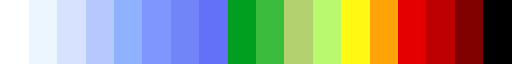

In [13]:
# importing cool (but maybe color-blindly wrong) color-palettes
cmaps.precip2_17lev

Assuming that **rain** is the variable we want to plot... <span style="color:RoyalBlue">[Both plots are done via xarray]</span>

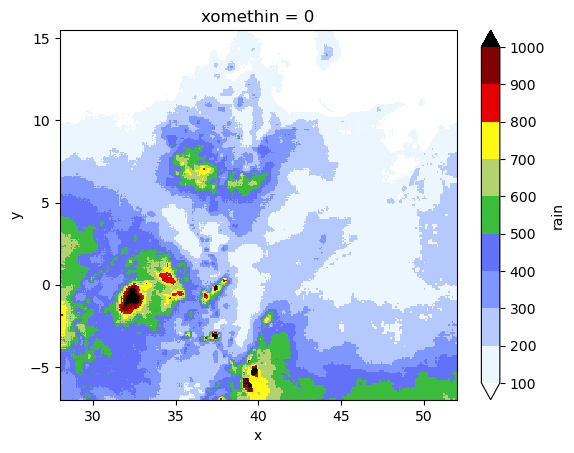

In [14]:
# realization in WGS84
xile.rain.plot(
    cmap="precip2_17lev",
    levels=10,
    vmin=100,
    vmax=1000,
    add_colorbar=True,  # robust=True,
)

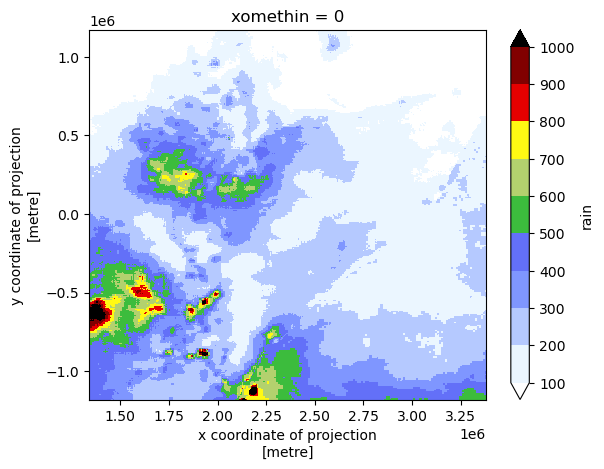

In [15]:
# realization in local CRS
pile.rain.plot(
    cmap="precip2_17lev",
    levels=10,
    vmin=100,
    vmax=1000,
    add_colorbar=True,  # robust=True,
)

## <u>REGIONALIZATION</u> ##

The catchment/region is needed here as/in Numpy format/type.\
<span style="color:RoyalBlue">Check [last section](tre_.ipynb#mask) of notebook [tre_](./tre_.ipynb).</span>

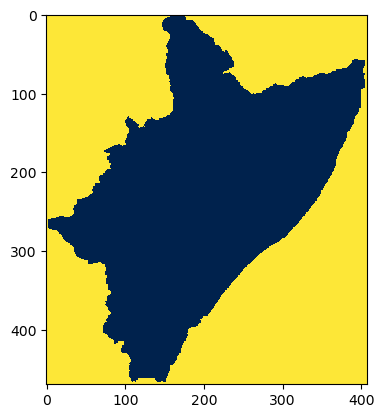

In [16]:
# reading the previously xported.numpy
CATCHMENT_MASK = np.load("tre_catchment-mask.npy")

# how does it look like?
plt.imshow(
    CATCHMENT_MASK, origin="upper", cmap="cividis_r", interpolation="none"
)  # .resampled(3))

Let's mask the pixels not representing the catchment/region out.

In [17]:
# # FOR A MASK IN THE WHOLE [RECTANGULAR] DOMAIN USE:
# mask_regn = np.ma.MaskedArray( pile.rain.data.copy(), False )

# FOR A MASK COMING FROM AN IRREGULAR DOMAIN/SHP USE:
mask_regn = np.ma.MaskedArray(pile.rain.data.copy(), ~CATCHMENT_MASK.astype("bool"))
# # ... in the line below (previous cases) BAND was removed!
# mask_regn = np.ma.MaskedArray(
#     real.rain["band" == 1, :].data.copy(), ~CATCHMENT_MASK.astype("bool")
# )

# let's have a look
print(mask_regn)

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


<span style="color:HotPink">*The masking seems to be OK.*</span>

### (MORE) STORM PARAMETERS ###
<a id='more'></a>
<span style="color:MediumSeaGreen">*Having this **CLUSTERS** parameter here is very handy (for some toying later) .*</span>

In [18]:
# number of regions to split the whole.region into
CLUSTERS = 4

# make a copy of the MASK and CLUSTERS
REG = mask_regn.copy()
N_C = CLUSTERS

Here we use some Machine Learning technique (i.e., [K-means](https://scikit-learn.org/stable/modules/clustering.html#k-means)) from the [scikit-learn](https://scikit-learn.org/stable/) library... to divide our realization into more "uniform" regions/zones.

In [19]:
# nans outside mask
REG[REG.mask] = np.nan
# ravel and indexing
ravl = REG.ravel()
idrs = np.arange(len(ravl))[~np.isnan(ravl)]
# transform the non-void (RGB?) field into 1D.numpy
X = ravl[idrs].data.reshape(-1, 1)

# clustering happens here
kmeans = KMeans(n_clusters=N_C, n_init=11, random_state=None).fit(X)

# expand the result into a void-array
ravl[idrs] = kmeans.labels_
LAB = ravl.reshape(REG.shape).data

# region labels
KAT = np.char.strip(kmeans.get_feature_names_out().astype("U"), "kmeans")
# https://stackoverflow.com/a/25715954/5885810  -> np.object to np.string
# https://www.w3resource.com/numpy/string-operations/strip.php  -> strip np.string.arrays

In [20]:
# can we see the regionalization in the numpy array?
print(LAB)
print(KAT)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
['0' '1' '2' '3']


### VISUALIZATION ###

We can definitely see the regionalization by plotting the **LAB** numpy.

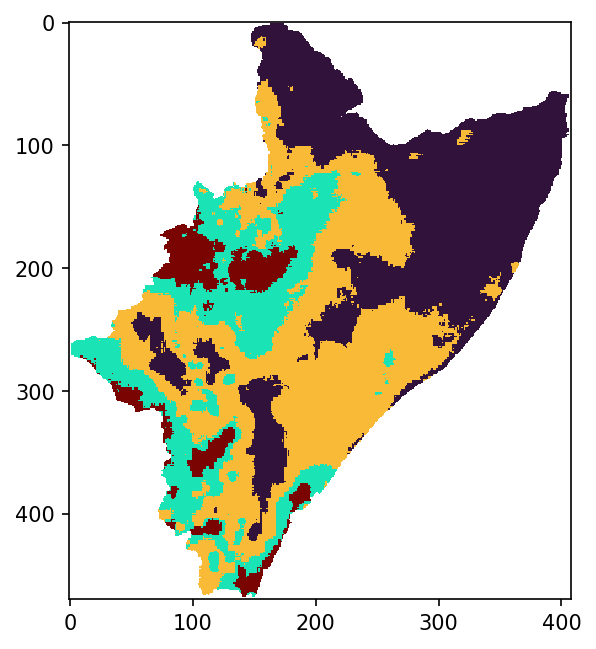

In [21]:
plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(LAB, origin="upper", cmap="turbo", interpolation="none")  # .resampled(3))

# # use these for exporting and cleaning
# plt.savefig(
#     "for_.pdf", bbox_inches="tight", pad_inches=0.02, facecolor=fig.get_facecolor()
# )
# plt.close()
# plt.clf()

What are the actual means of the regions/classes?

In [22]:
cdic = dict(zip(KAT, kmeans.cluster_centers_))
cdic

{'0': array([120.833336], dtype=float32),
 '1': array([367.94604], dtype=float32),
 '2': array([230.80005], dtype=float32),
 '3': array([575.4106], dtype=float32)}

Plot the realization (xarray **pile**) in local CRS, but this time only for the catchment/region mask.

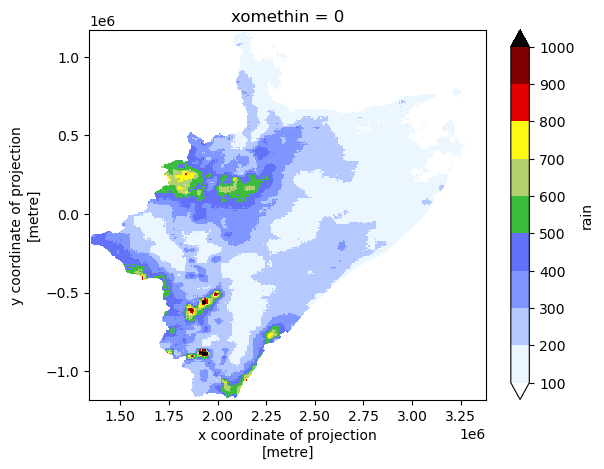

In [23]:
# masked realization in local CRS
pile.rain.where(~np.isnan(REG.data), np.nan).plot(
    cmap="precip2_17lev", levels=10, vmin=100, vmax=1000, add_colorbar=True
)

### MORPHOLOGICAL FILTERING ###

Maybe there is not need to have a detailed delimitation among the region/zones.
Such a detail might translate in slowing STORM computations by having SHPs with too many points.
Hence, decreasing the resolution of the boundaries will speed STORM's performance (by having SHPs with much less vertices/points).

<span style="color:HotPink">*Note: Following this approach implies that the actual means won't precisely correspond to the newly delimited regions.*</span>

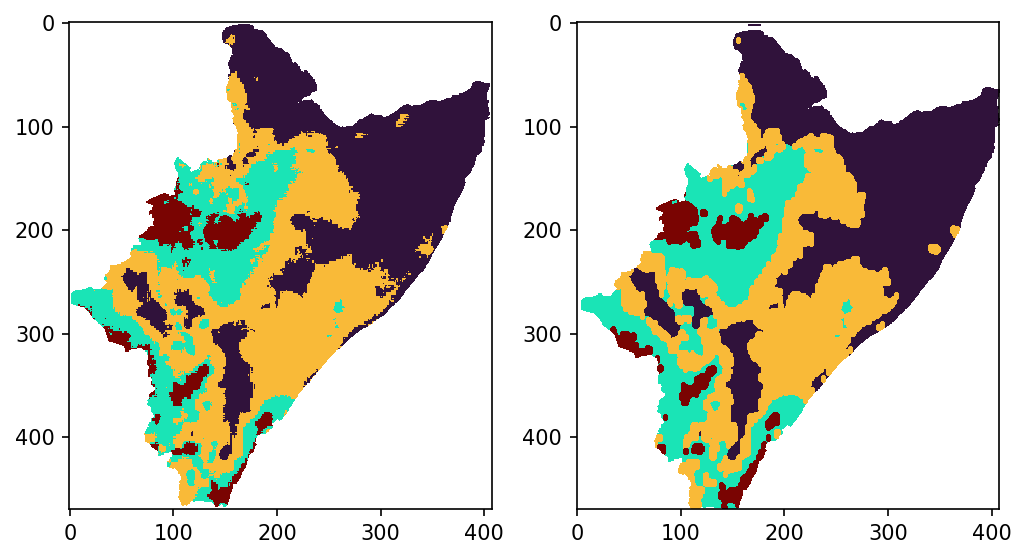

In [24]:
# "decreasing resolution"
new = morphology.opening(LAB, morphology.ellipse(2, 3))

# plots and comparison
fig, ax = plt.subplots(1, 2, figsize=(8, 5), dpi=150)
ax[0].imshow(LAB, origin="upper", cmap="turbo", interpolation="none")
ax[1].imshow(new, origin="upper", cmap="turbo", interpolation="none")

### REGIONALIZATION MASKS TO NUMPYs ###

<span style="color:RoyalBlue">*Such a conversion is necessary for STORM to simulate storms within such regions/masks.*</span>

In [25]:
# copy the masks
mopen = new
# mopen = LAB

# NUMPY to SHAPE
# .rio.transform() IS QUITE OF THE ESSENCE HERE!
lopen = list(
    shapes(mopen, mask=CATCHMENT_MASK, connectivity=4, transform=pile.rio.transform())
)

# we didn't read "BUFFRX_MASK" though!
# lopen = list( shapes(mopen, mask=BUFFRX_MASK, connectivity=4, transform=real.rio.transform()) )

# remove NAN.regions??
# https://stackoverflow.com/a/25050572/5885810
# https://stackoverflow.com/a/3179137/5885810
lopen = [x for x, y in zip(lopen, ~np.isnan(list(zip(*lopen))[-1])) if y]
lopen = list(
    map(
        lambda x: dict(
            geometry=x[0],
            properties={
                "label": f"region{int(x[-1])}",
            },
        ),
        lopen,
    )
)

# into GEOPANDAS
feats = gpd.GeoDataFrame.from_features({"type": "FeatureCollection", "features": lopen})
# # the line below is an alternative... BUT you mig have troubles grouping it
# feats = gpd.GeoDataFrame.from_dict(
#     list(
#         shapes(mopen, mask=BUFFRX_MASK, connectivity=4, transform=real.rio.transform())
#     ),
# )

# grouping to retrieve just the CLUSTER.masks (the output is a Series)
nasks = feats.groupby(by="label").apply(lambda x: x.unary_union)

Visualizing the different masks/regions...

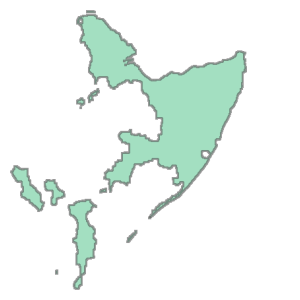

In [26]:
nasks[0]

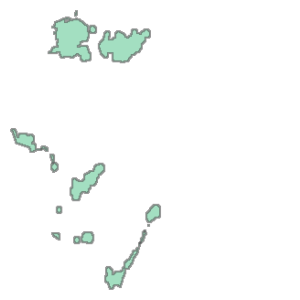

In [27]:
nasks[-1]

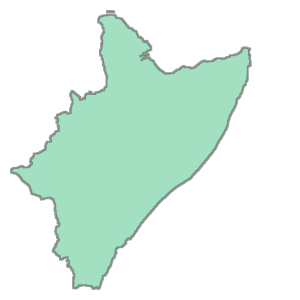

In [28]:
# do we obtain HAD if merging all masks?
feats.unary_union

<span style="color:RoyalBlue">If you want to have them grouped into a [GeoPandas](https://geopandas.org/en/stable/).</span>

In [29]:
# turn them back into GeoPandas
masks = gpd.GeoDataFrame(geometry=nasks)
# masks.geometry.iloc[0]
# masks.geometry.loc['region0']
# masks.loc['region0'].geometry
# masks.geometry.xs('region0')

masks

,geometry
label,
region0,"MULTIPOLYGON (((1930000.000 -830000.000, 19300..."
region1,"MULTIPOLYGON (((1950000.000 -1070000.000, 1955..."
region2,"MULTIPOLYGON (((1935000.000 -985000.000, 19300..."
region3,"MULTIPOLYGON (((1880000.000 -915000.000, 18750..."


<span style="color:MediumSeaGreen">I'd would ask then... what would the above exercise look like if [**CLUSTERS**](#more) is equal to **1**... or **3**... or **7**??</span>

#### *A PEEK INTO WHAT IT'S PASSED TO STORM* ####

In [30]:
real = pile.copy(deep=True)

# https://realpython.com/iterate-through-dictionary-python/
for keys, values in dict(
    zip(
        ["catchm", "cacth", "kmeans", "region"],
        [CATCHMENT_MASK, CATCHMENT_MASK, LAB, mopen],
    )
).items():
    real[keys] = xr.DataArray(values, coords=void.coords, dims=void.coords.dims)
    # real[keys] = xr.DataArray(values, coords=real.coords, dims=real.coords.dims)

# trims "real['region']"
# trimming around the CATCHMENT_MASK is what we want; as we compute PTOT within "catchm"
real["region"] = xr.where(real.catchm == 1, real.region, -1)
# # -trims around the BUFFER -> (this we want NOT!)
# real["region"] = xr.where(real.buffer == 1, real.region, -1)

# -THESE 3 vars ARE IN THE ORDER OF cdic.keys()
# new means (regions inside the HAD)
# old_ks = list(
#     map(lambda x: real.rain.where(real.kmeans == int(x)).mean().data, cdic.keys())
# )
new_ks = list(
    map(
        lambda x: real.rain.where(real.catchm == 1, np.nan)
        .where(real.kmeans == int(x))
        .mean()
        .data,
        cdic.keys(),
    )
)

# numpy masks
# ... 1st transform K-mean into 1s (because of the 0 K-mean); and the assign 0 everywhere else
reg_np = list(
    map(
        lambda x: real.region.where(real.region != int(x), 1)
        .where(real.region == int(x), 0)
        .data.astype("u1"),
        cdic.keys(),
    )
)

# shapes
# # the line below are "pandas.core.series.Series"
# zhapez = list(map(lambda x: masks.loc[f"region{int(x)}"], cdic.keys()))
# ...in case "pandas.core.series.Series" try converting them into "geopandas.geodataframe.GeoDataFrame"
zhapez = list(
    map(
        lambda x: gpd.GeoDataFrame(
            geometry=masks.loc[f"region{int(x)}"], crs=void.rio.crs
        ).set_index(RangeIndex(0, 1, 1)),
        cdic.keys(),
    )
)
# zhapez = list(
#     map(
#         lambda x: gpd.GeoDataFrame(geometry=masks.loc[f"region{int(x)}"]).set_index(
#             RangeIndex(0, 1, 1)
#         ),
#         cdic.keys(),
#     )
# )

# grouping the output into a dict
output = dict(zip(("mask", "npma", "rain"), (zhapez, reg_np, new_ks)))
output["kmeans"] = xr.where(real.catchm == 1, real.kmeans, -1).data.astype("i1")

output

{'mask': [                                            geometry
  0  MULTIPOLYGON (((1930000.000 -830000.000, 19300...,
                                              geometry
  0  MULTIPOLYGON (((1950000.000 -1070000.000, 1955...,
                                              geometry
  0  MULTIPOLYGON (((1935000.000 -985000.000, 19300...,
                                              geometry
  0  MULTIPOLYGON (((1880000.000 -915000.000, 18750...],
 'npma': [array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
     